# Retail Marketing Analysis

This project demonstrates a complete marketing analytics workflow using real-world e-commerce transaction data. It involves loading, cleaning, and transforming raw retail data into actionable insights and visualizations. Ideal for marketing analysts and data scientists working with customer behavior and sales trends.

### Key Steps:
- Loads `Online Retail.xlsx` data
- Cleans data (removes cancellations, negative quantity/price, missing IDs)
- Computes core KPIs and exports cleaned dataset
- Generates visual insights:
  - Monthly Revenue Trend
  - Top Products by Revenue
  - Top Countries by Revenue
  - RFM Segmentation (Recency, Frequency, Monetary)
  - Cohort Retention Analysis
- Saves feature tables to CSV for further modeling

### Tools Required:
- `pandas`
- `numpy`
- `matplotlib`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
DATA_PATH = Path("Online Retail.xlsx")  # change if file is elsewhere
OUT_DIR = Path(".")
OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOT_SHOW = True  # set False if running headless and you only want CSV outputs

In [27]:
# 1) LOADING

In [6]:
if not DATA_PATH.exists():
    # Also try current working dir and /mnt/data if not found
    alt = Path("/mnt/data/Online Retail.xlsx")
    if alt.exists():
        DATA_PATH = alt
    else:
        raise FileNotFoundError("Cannot find 'Online Retail.xlsx'. Place it next to this script or update DATA_PATH.")

df_raw = pd.read_excel(DATA_PATH)

In [28]:
# 2) CLEANING

In [29]:
df = df_raw.copy()

# Remove missing key fields
df = df.dropna(subset=["InvoiceNo", "StockCode"])

# Remove credit notes (InvoiceNo starting with 'C')
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Keep positive quantity and unit price
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Compute line revenue
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Parse datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Use nullable int for CustomerID (keep nulls for row-level analysis; drop later for RFM)
df["CustomerID"] = df["CustomerID"].astype("Int64")

# Save cleaned
clean_path = OUT_DIR / "online_retail_clean.csv"
df.to_csv(clean_path, index=False)

In [30]:
# 3) KPI SNAPSHOT

In [31]:
kpis = {
    "unique_customers": int(df["CustomerID"].dropna().nunique()),
    "unique_invoices": int(df["InvoiceNo"].nunique()),
    "unique_products": int(df["StockCode"].nunique()),
    "date_min": df["InvoiceDate"].min(),
    "date_max": df["InvoiceDate"].max(),
    "total_revenue": float(df["TotalPrice"].sum()),
}
kpi_df = pd.DataFrame([kpis])
kpi_df.to_csv(OUT_DIR / "online_retail_kpis.csv", index=False)
print("KPI Snapshot:\n", kpi_df.to_string(index=False))

KPI Snapshot:
  unique_customers  unique_invoices  unique_products            date_min            date_max  total_revenue
             4338            19960             3922 2010-12-01 08:26:00 2011-12-09 12:50:00   10666684.544


In [32]:
# 4) MONTHLY REVENUE TREND

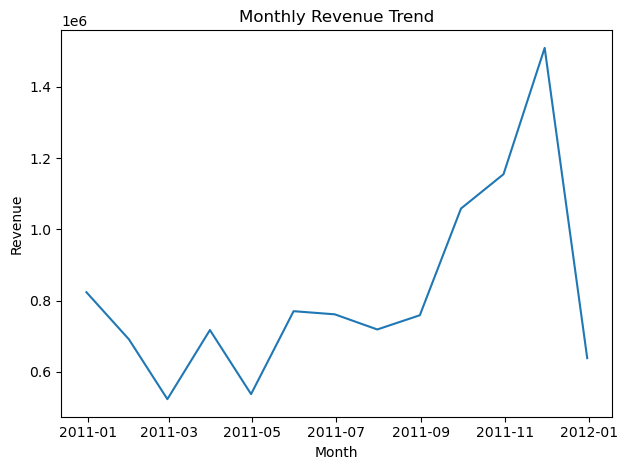

In [47]:
monthly = (
    df.set_index("InvoiceDate")["TotalPrice"]
      .resample("ME")
      .sum()
      .rename("Revenue")
      .to_frame()
)
monthly_path = OUT_DIR / "online_retail_monthly_revenue.csv"
monthly.reset_index().to_csv(monthly_path, index=False)

if PLOT_SHOW:
    plt.figure()
    plt.plot(monthly.index, monthly["Revenue"])
    plt.title("Monthly Revenue Trend")
    plt.xlabel("Month")
    plt.ylabel("Revenue")
    plt.tight_layout()
    plt.show()

In [37]:
# 5) TOP PRODUCTS BY REVENUE  

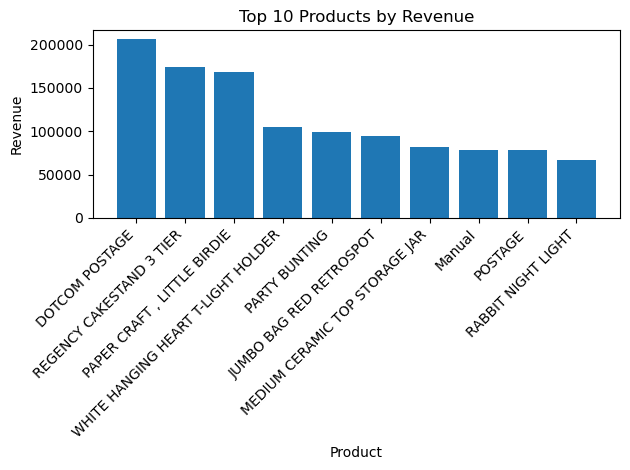

In [38]:
top_products = (
    df.groupby(["StockCode", "Description"], dropna=False)["TotalPrice"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
      .rename(columns={"TotalPrice": "Revenue"})
)
top_products.to_csv(OUT_DIR / "online_retail_top_products.csv", index=False)

if PLOT_SHOW:
    plt.figure()
    plt.bar(top_products["Description"].astype(str), top_products["Revenue"])
    plt.title("Top 10 Products by Revenue")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Product")
    plt.ylabel("Revenue")
    plt.tight_layout()
    plt.show()

In [39]:
# 6) TOP COUNTRIES BY REVENUE

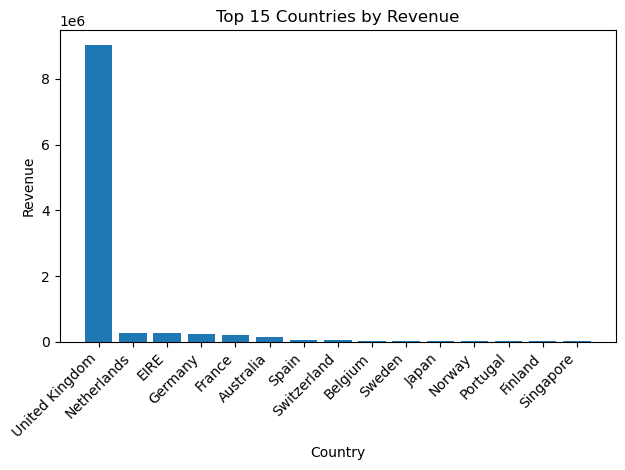

In [40]:
country_rev = (
    df.groupby("Country")["TotalPrice"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
      .reset_index()
      .rename(columns={"TotalPrice": "Revenue"})
)
country_rev.to_csv(OUT_DIR / "online_retail_top_countries.csv", index=False)

if PLOT_SHOW:
    plt.figure()
    plt.bar(country_rev["Country"], country_rev["Revenue"])
    plt.title("Top 15 Countries by Revenue")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Country")
    plt.ylabel("Revenue")
    plt.tight_layout()
    plt.show()

In [43]:
# 7) RFM SEGMENTATION

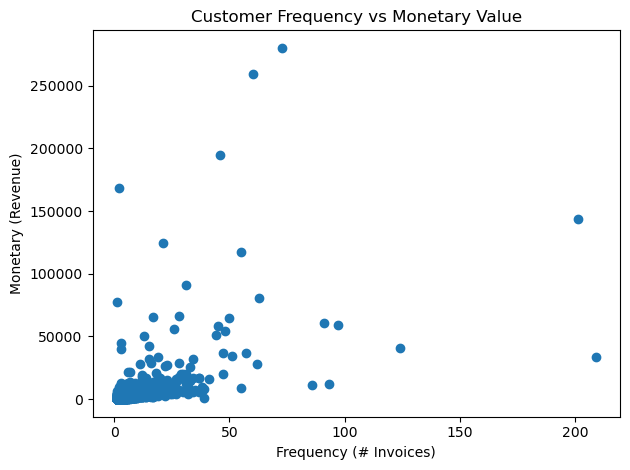

In [42]:
cust = df.dropna(subset=["CustomerID"]).copy()
ref_date = cust["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = cust.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (ref_date - x.max()).days),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("TotalPrice", "sum")
).reset_index()

# Quartiles: R 1(best)-4(worst); F & M 4(worst)-1(best) reversed via labels
rfm["R_quartile"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F_quartile"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_quartile"] = pd.qcut(rfm["Monetary"].rank(method="first"), 4, labels=[1,2,3,4])

rfm["RFM_Score"] = rfm["R_quartile"].astype(str) + rfm["F_quartile"].astype(str) + rfm["M_quartile"].astype(str)
rfm["RFM_Sum"] = rfm[["R_quartile", "F_quartile", "M_quartile"]].astype(int).sum(axis=1)

def map_segment(row):
    s = row["RFM_Sum"]
    if s <= 5:
        return "Champions"
    if s <= 7:
        return "Loyal"
    if s <= 9:
        return "Potential Loyalists"
    if s <= 11:
        return "At Risk"
    return "Hibernating"

rfm["Segment"] = rfm.apply(map_segment, axis=1)

rfm_path = OUT_DIR / "online_retail_rfm.csv"
rfm.to_csv(rfm_path, index=False)

if PLOT_SHOW:
    plt.figure()
    plt.scatter(rfm["Frequency"], rfm["Monetary"])
    plt.title("Customer Frequency vs Monetary Value")
    plt.xlabel("Frequency (# Invoices)")
    plt.ylabel("Monetary (Revenue)")
    plt.tight_layout()
    plt.show()

In [44]:
# 8) 8) COHORT RETENTION

In [45]:
cust["InvoiceMonth"] = cust["InvoiceDate"].dt.to_period("M")
first_purchase = cust.groupby("CustomerID")["InvoiceMonth"].min()
cust = cust.join(first_purchase.rename("CohortMonth"), on="CustomerID")

def cohort_index(df_in):
    return (df_in["InvoiceMonth"].dt.to_timestamp() - df_in["CohortMonth"].dt.to_timestamp()).dt.days // 30

cust["CohortIndex"] = cohort_index(cust)

cohort_counts = (
    cust.groupby(["CohortMonth", "CohortIndex"])["CustomerID"].nunique().reset_index()
    .pivot(index="CohortMonth", columns="CohortIndex", values="CustomerID")
    .fillna(0)
    .astype(int)
)
cohort_sizes = cohort_counts[0].replace(0, np.nan)
retention = cohort_counts.divide(cohort_sizes, axis=0)

retention_path = OUT_DIR / "online_retail_cohort_retention.csv"
retention.reset_index().to_csv(retention_path, index=False)

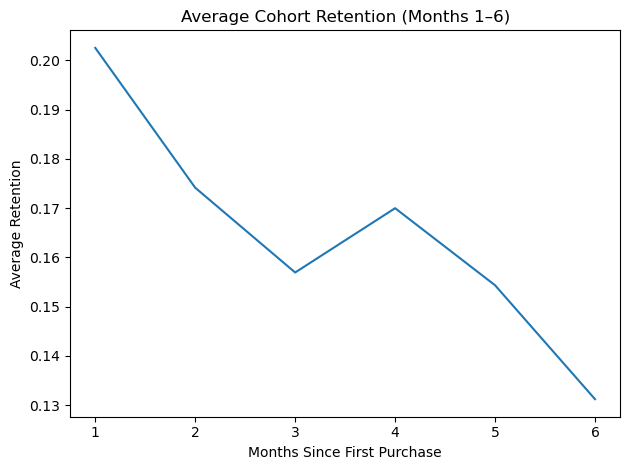

Saved:
 - /Users/mahimasanghvi/Projects/1/online_retail_clean.csv
 - /Users/mahimasanghvi/Projects/1/online_retail_monthly_revenue.csv
 - /Users/mahimasanghvi/Projects/1/online_retail_top_products.csv
 - /Users/mahimasanghvi/Projects/1/online_retail_top_countries.csv
 - /Users/mahimasanghvi/Projects/1/online_retail_rfm.csv
 - /Users/mahimasanghvi/Projects/1/online_retail_cohort_retention.csv


In [46]:
cols = [c for c in retention.columns if isinstance(c, (int, np.integer)) and 1 <= c <= 6]
if cols:
    avg_ret = retention[cols].mean(axis=0).dropna()
    if PLOT_SHOW and not avg_ret.empty:
        plt.figure()
        plt.plot(avg_ret.index.astype(int), avg_ret.values)
        plt.title("Average Cohort Retention (Months 1–6)")
        plt.xlabel("Months Since First Purchase")
        plt.ylabel("Average Retention")
        plt.tight_layout()
        plt.show()

print("Saved:")
print(" -", clean_path.resolve())
print(" -", monthly_path.resolve())
print(" -", (OUT_DIR / "online_retail_top_products.csv").resolve())
print(" -", (OUT_DIR / "online_retail_top_countries.csv").resolve())
print(" -", rfm_path.resolve())
print(" -", retention_path.resolve())

## Analysis Summary: Online Retail Marketing Insights

This project explored real-world e-commerce transaction data to generate actionable marketing insights using Python.

### Data Cleaning & Preparation
The dataset was filtered to ensure data quality by removing:
- Canceled transactions (`InvoiceNo` starting with `'C'`)
- Negative quantities or prices
- Missing customer or product identifiers

**Final dataset:**  
- 4,338 unique customers  
- 19,960 invoices  
- Over £10 million in total revenue

### Key Insights from Visualizations

**1. Monthly Revenue Trend**  
- Revenue rose sharply in Q4 2011, peaking in November.  
- Indicates strong seasonality—likely due to holiday shopping.

**2. Top Products by Revenue**  
- Highest revenue products include:  
  - `DOTCOM POSTAGE`  
  - `REGENCY CAKESTAND 3 TIER`  
- These items are likely gift-related, supporting the seasonal trend.

**3. Top Countries by Revenue**  
- The **United Kingdom** is the dominant revenue contributor.  
- Other countries like Netherlands, Germany, and France show potential but lag far behind.  
- Highlights opportunity for international expansion.

**4. RFM Segmentation (Recency, Frequency, Monetary)**  
- Most customers are low-frequency and low-monetary buyers.  
- A small but valuable segment exists with high purchase frequency and spend.  
- These customers could be classified as VIPs.

**5. Cohort Retention Analysis**  
- Customer retention significantly drops after the first month.  
- Suggests high acquisition but weak long-term engagement.  
- Indicates a need for better post-purchase strategies.

### Business Recommendations

- **Capitalize on Q4 seasonality**  
  Launch early and personalized holiday campaigns.

- **Improve retention**  
  Create follow-up email workflows and loyalty incentives for first-time buyers.

- **Target high-value segments**  
  Offer VIP perks, referral bonuses, or subscription bundles.

- **Expand internationally**  
  Prioritize marketing spend in top non-UK regions with localized offers.

- **Use RFM for segmentation**  
  Personalize campaigns based on customer behavior:  
  - Lapsed users  
  - One-time buyers  
  - Loyal champions

This analysis provides a foundation for data-driven marketing decisions in retail, helping identify high-impact strategies to increase both revenue and customer retention.